# Forsøk på debugging (klart det 🥳)

Har for så vidt klart det 😮‍💨 Den trener bra på kun én kampanje! Dette må vi bygge videre på!

### Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from time import time

In [54]:
def read_dataset(filename, campaign=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    X, y = df[['RSRP', 'SSS_RSRP', 'campaign', 'Mode']], df['Mode']
    return X, y


def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f): # check to see if we are bwyond the data set
            break

        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)


def vertical_handover(y):
    new_y = []
    for seq in y:
        if seq.__contains__(0) and seq.__contains__(1):
            new_y.append(1)
        else:
            new_y.append(0)
    return np.array(new_y)


def check_handover(y):
    new_y = [0]
    for i in range(len(y) - 1):
        if y[i] == y[i+1]:
            new_y.append(0)
        else:
            new_y.append(1)
    return np.array(new_y)

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


def precision_recall(y_pred, y_true):
    tp, fp, fn =  0, 0, 0

    # Loop through true and predicted labels to count TP, FP, and FN
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1

    # Precision calculation
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    # Recall calculation
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    return precision, recall

In [55]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
X, y = read_dataset('datasets/Op1_merged.csv', campaign=campaign)

n_steps_in, n_steps_out = 2, 1
X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2

X_train, y_train = X[len(y) - train_size ::], y[len(y) - train_size ::]
X_val, y_val = X[0 : test_size], y[0 : test_size]
X_test, y_test = X[test_size : len(y) - train_size], y[test_size : len(y) - train_size]
y_test_changed = vertical_handover(y_test)

n_features = X_train.shape[2]

In [56]:
model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=15,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=15,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
start = time()
History = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True, verbose=0)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 14.42 secs
-----------------------------------------------------------------


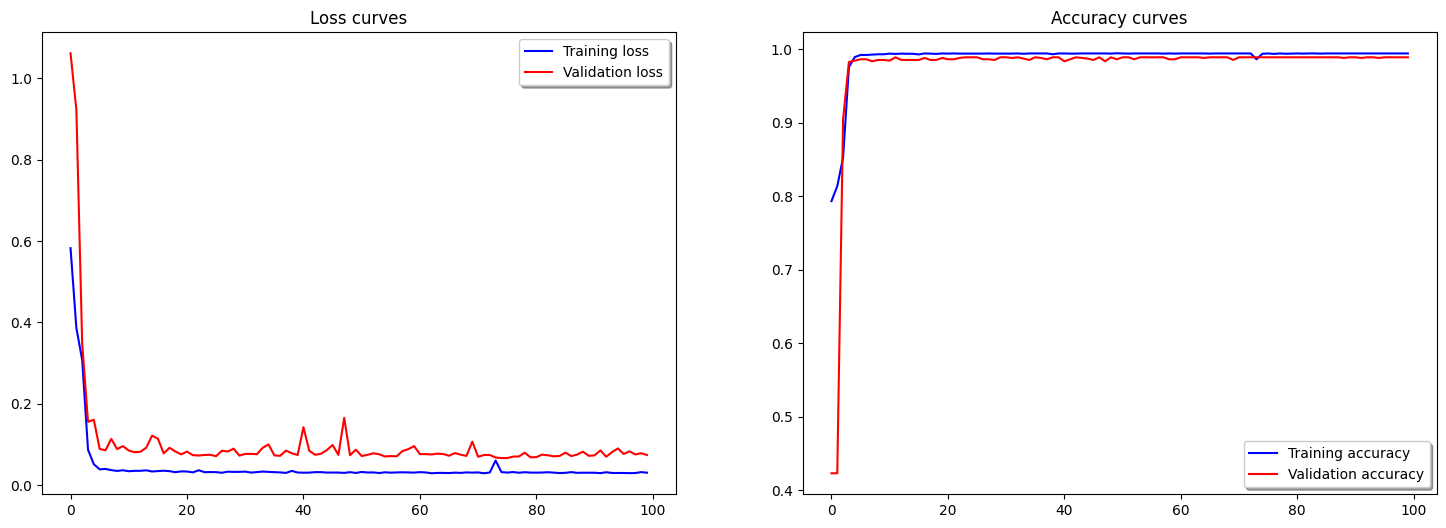

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [59]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_pred_changed = check_handover(y_pred)

print(f'Accuracy: {accuracy(y_pred, y_test):.3f}')
precision, recall = precision_recall(y_pred, y_test)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.990
Precision: 0.987
Recall: 0.985


## Hele datasettet

In [60]:
X, y = read_dataset('datasets/Op1_merged.csv')

n_steps_in, n_steps_out = 2, 1
X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2

X_train, y_train = X[len(y) - train_size ::], y[len(y) - train_size ::]
X_val, y_val = X[0 : test_size], y[0 : test_size]
X_test, y_test = X[test_size : len(y) - train_size], y[test_size : len(y) - train_size]
y_test_changed = vertical_handover(y_test)

n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=20,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=20,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
start = time()
History = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True, verbose=0)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 67.71 secs
-----------------------------------------------------------------


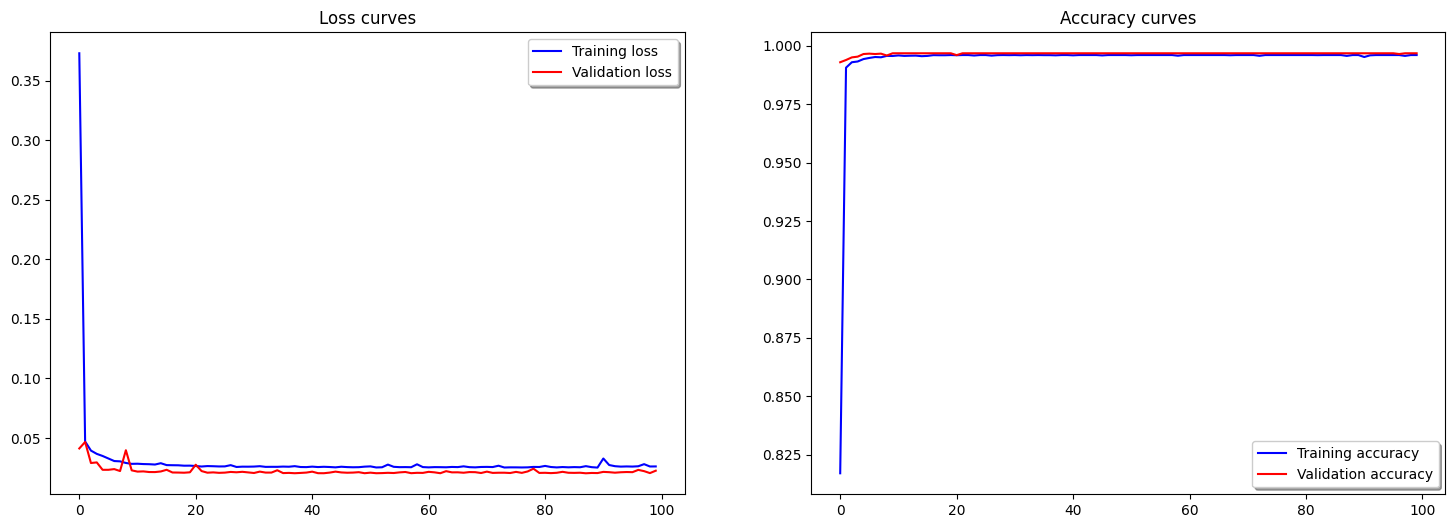

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [63]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_pred_changed = check_handover(y_pred)

print(f'Accuracy on handovers: {accuracy(y_pred_changed, y_test_changed):.3f}')
print(f'Accuracy on single points: {accuracy(y_pred, y_test):.3f}')
precision, recall = precision_recall(y_pred, y_test)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
Accuracy on handovers: 0.997
Accuracy on single points: 0.997
Precision: 0.990
Recall: 0.990


## Flere steg frem

In [75]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
X, y = read_dataset('datasets/Op1_merged.csv', campaign=campaign)

n_steps_in, n_steps_out = 10, 5
X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2

X_train, y_train = X[len(y) - train_size ::], y[len(y) - train_size ::]
X_val, y_val = X[0 : test_size], y[0 : test_size]
X_test, y_test = X[test_size : len(y) - train_size], y[test_size : len(y) - train_size]
y_test_changed = vertical_handover(y_test)

n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=50,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=50,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
start = time()
History = model.fit(X_train, y_train,
                    epochs=150,
                    validation_data=(X_val, y_val),
                    shuffle=True, verbose=0)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 74.22 secs
-----------------------------------------------------------------


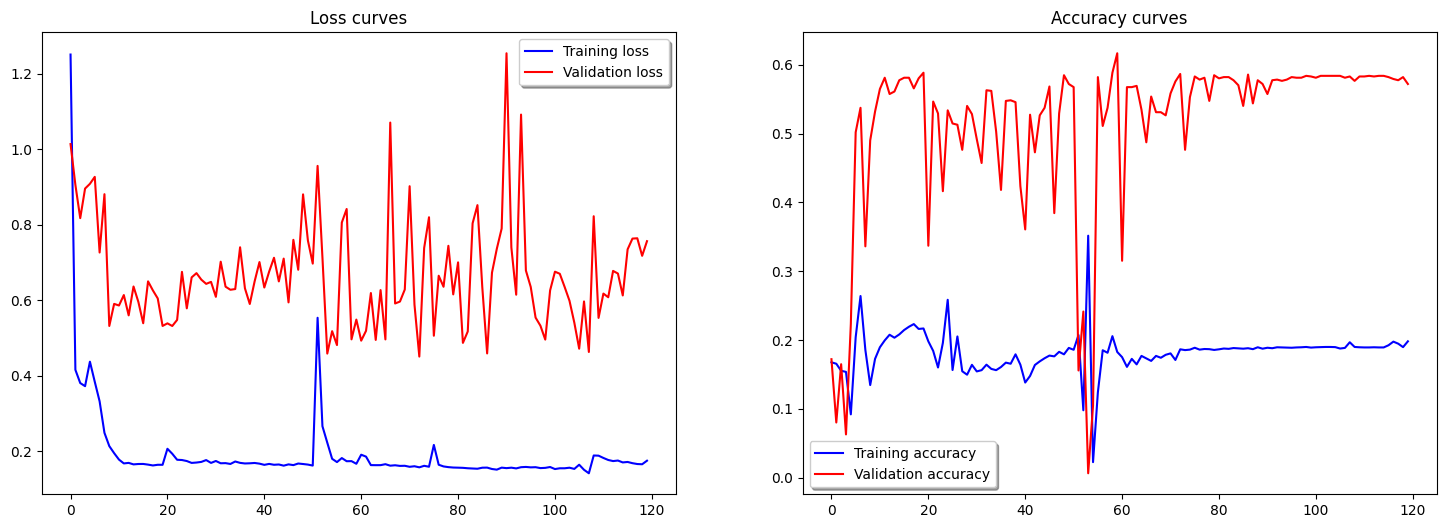

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [67]:
# Her har vi et problem med at enten så predikerer modellen bare 5g eller 4g

y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_pred_changed = vertical_handover(y_pred)

print(f'Accuracy: {accuracy(y_pred, y_test):.3f}')
precision, recall = precision_recall(y_pred_changed, y_test_changed)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.966
Precision: 0.143
Recall: 0.023
